In [39]:
# Import libraries

# Essential stuff

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os



# You can do without them if you really want to code everything from scratch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers
from tensorflow.keras import losses

# Just because I don't want to type tf.keras.layers every time

tfk = tf.keras              
tfkl = tf.keras.layers

In [31]:
# Load data using pandas

data = pd.read_csv("college_student_management_data.csv", delimiter=',')
data.head()

,student_id,age,gender,major,GPA,course_load,avg_course_grade,attendance_rate,enrollment_status,lms_logins_past_month,avg_session_duration_minutes,assignment_submission_rate,forum_participation_count,video_completion_rate,risk_level
0,S001,24,Other,Computer Science,2.42,5,67.2,0.71,Graduated,32,33,0.70,8,0.74,High
1,S002,21,Male,Arts,3.73,6,64.4,0.84,Leave,29,53,0.91,13,0.85,Medium
2,S003,22,Male,Computer Science,2.80,3,95.3,0.89,Graduated,34,69,0.58,18,0.99,Medium
3,S004,24,Male,Arts,2.59,4,73.7,0.98,Graduated,22,18,0.91,6,0.72,Medium
4,S005,20,Other,Computer Science,2.30,4,87.4,0.95,Active,9,11,0.77,15,0.76,High


In [32]:
data_risk=data.copy()

label_encoders = {}

label_encoder = LabelEncoder()
data_risk['risk_level'] = label_encoder.fit_transform(data_risk['risk_level'])

data_risk = pd.get_dummies(data_risk, columns=['gender', 'major', 'enrollment_status'], drop_first=True)

# Normalizarea datelor
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)



In [33]:
# Separate Target Variable and Feature Variables

Target=['risk_level']                                                            # what we want to predict
# Features =['age', 'GPA', 'course_load', 'avg_course_grade', 'attendance_rate', 'lms_logins_past_month', 'avg_session_duration_minutes', 'assignment_submission_rate', 'forum_participation_count', 'video_completion_rate']          # features that determine de price (hopefully)
Features = [col for col in data_risk.columns if col not in ['student_id', 'risk_level']]


# x_features =data_normed[Features].values            # returns a Numpy representation of the DataFrame
# y_target =data_normed[Target].values

x_features = data_risk[Features].values
y_target = data_risk['risk_level'].values

In [34]:
print(x_features.shape)
print(y_target.shape)

(1545, 17)
(1545,)


### Split the data into test, train and validation

In [54]:
# Prepare test, train and validation data for the model

x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=15129)
# x_train, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=15129)

x_train = x_train.astype(np.float32)
# x_val = x_val.astype(np.float32)
x_test = x_test.astype(np.float32)

y_train = y_train.astype(np.int32)
# y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

In [36]:
# Sanity check with the shapes of Training,testing and validation datasets

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(756, 17)
(756,)
(464, 17)
(464,)
(325, 17)
(325,)


In [55]:
# Create the ANN architecture

model = tfk.Sequential(
    [
    tfkl.InputLayer(input_shape=(x_train.shape[1],)),
    tfkl.Dense(64, activation='relu', name="Hidden_Layer_1", kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    tfkl.Dense(32, activation='relu', name="Hidden_Layer_2", kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    tfkl.Dense(16, activation='relu', name="Hidden_Layer_3", kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    # tfkl.Dense(16, activation="sigmoid", name="Hidden_Layer_3", kernel_initializer='he_normal', bias_initializer='random_uniform'),
    # tfkl.Dense(32, activation='leaky_relu', name="Hidden_Layer_3", kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    # tfkl.Dense(300, activation="leaky_relu", name="Hidden_Layer_3", kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    # tfkl.Dense(500, activation="leaky_relu", name="Hidden_Layer_4", kernel_initializer='he_normal', bias_initializer='random_uniform'),
    # tfkl.Dense(600, activation="leaky_relu", name="Hidden_Layer_5", kernel_initializer='he_normal', bias_initializer='random_uniform'),
    # tfkl.Dense(1, name="Output_Layer",activation="sigmoid")
    tfkl.Dense(3, name="Output_Layer",activation="softmax")
    ]
)

/home/glosper/anaconda3/envs/tf216/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [57]:
# Set number of epochs and batch size

epochs = 300
batch_size = 32

# Set the optimizer

# opt = tfk.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
# opt = tfk.optimizers.SGD(learning_rate=0.01)
opt = tfk.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

#Compile the model

model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

y_train = y_train.ravel()
# y_val = y_val.ravel()
y_test = y_test.ravel()


# Fit model to training data and compute loss + other metrics

history = model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    # validation_data=(x_val, y_val), 
    validation_split=0.2,
    shuffle=True
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_3 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,811 (14.89 KB)

 Trainable params: 3,811 (14.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5070 - loss: 1.0111 - val_accuracy: 0.4839 - val_loss: 1.0402
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5121 - loss: 1.0163 - val_accuracy: 0.4839 - val_loss: 1.0402
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5049 - loss: 1.0283 - val_accuracy: 0.4839 - val_loss: 1.0402
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5267 - loss: 1.0118 - val_accuracy: 0.4839 - val_loss: 1.0403
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5279 - loss: 1.0078 - val_accuracy: 0.4839 - val_loss: 1.0403
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5520 - loss: 0.9809 - val_accuracy: 0.4839 - val_loss: 1.0404
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5231 - loss: 1.0048 - val_accuracy: 0.4839 - val_loss: 1.0403
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5324 - loss: 0.9990 - val_accuracy: 0.4839 - v

In [44]:
# Make a prediction for the test data

y_pred = model.predict(x_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


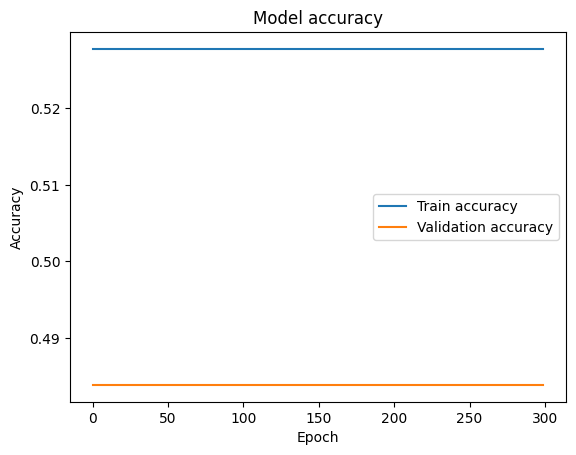

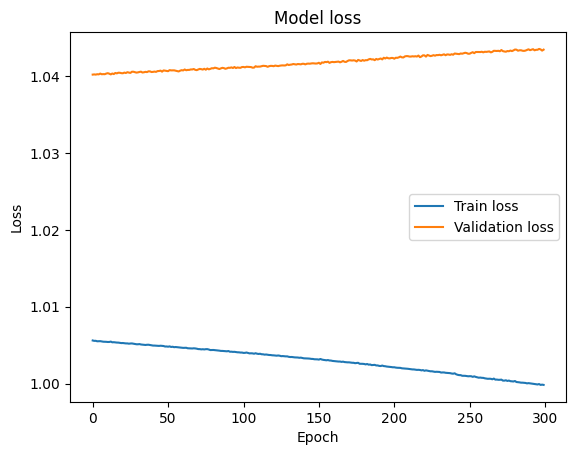

In [58]:
# Plotare acuratețe
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model accuracy')
plt.show()

# Plotare loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model loss')
plt.show()